In [15]:
%matplotlib inline

import numpy
import pandas
import matplotlib.pyplot as plt

import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn import metrics

import librosa
import librosa.display

In [121]:
import tarfile
import re
import io
    
def load_dataset(tarpath, labelpath, limit=None):
    labels = pandas.read_csv(labelpath, index_col='itemid')
    dataset = []
    labeldata = []
    
    with tarfile.open(tarpath, mode="r|gz") as tar:
        regex = r".*\/(\d+)\..*"
        for i, member in enumerate(tar):
            if limit is not None:
                if i >= limit:
                    break

            sample = int(re.findall(regex, member.name)[0])
            content = tar.extractfile(member).read()
            data = pandas.read_csv(io.BytesIO(content), encoding='utf8')

            #features = features_from_mfcc(data)
            features = data
            hasbird = labels.hasbird[sample].astype('bool')
            dataset.append(features)
            labeldata.append(hasbird)
        
    return dataset, labeldata


def meansub(s):
    return s - (numpy.mean(s, axis=0) + 1e-8)

# TODO: also calculate delta-frame features?
def features_from_mfcc(stored):
    mfcc = stored.T
    mfcc = meansub(mfcc)
    mfcs = mfcc / numpy.sum(mfcc)
    
    features = numpy.concatenate([
        numpy.mean(mfcc, axis=1),
        numpy.std(mfcc, axis=1)
    ])
    
    return features

def get_features(dataset):
    data, labels = dataset
    features = [features_from_mfcc(m) for m in data]
    return numpy.array(features), numpy.array(labels)

In [122]:
dataset = load_dataset('data/ff1010bird.mfcc.tgz', 'data/ff1010bird.labels.csv', limit=2000)
X, Y = get_features(dataset)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.3, random_state=1)
X.shape, Y.shape, numpy.mean(Y)

((2000, 40), (2000,), 0.233)

(20, 431)
(20,)


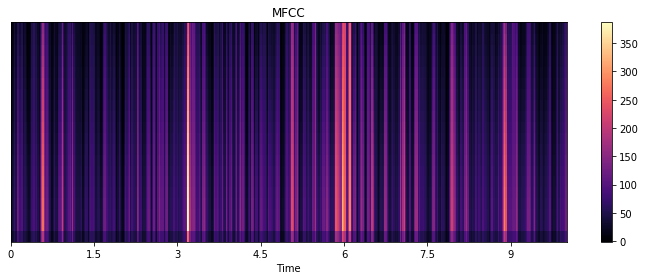

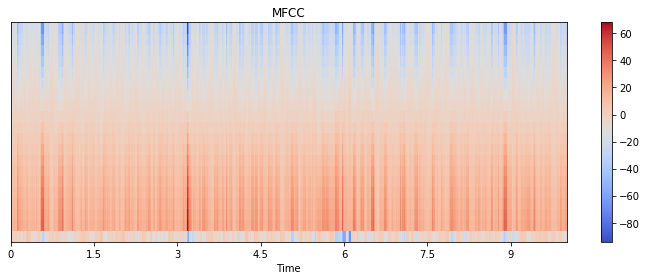

In [43]:
def plot_mfcc(mfcc):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()

def plot_spectrogram(S, title='Mel spectrogram', fmax=8000):
    plt.figure(figsize=(10, 4))
    d = librosa.power_to_db(S, ref=numpy.max)
    librosa.display.specshow(d, y_axis='mel', x_axis='time', fmin=500, fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()

print(X[1].T.shape)
print(numpy.mean(X[1].T, axis=1).shape)

plot_mfcc(X[1].T.values)
plot_mfcc(meansub(X[1].T.values))

In [107]:
def plot_precision_recall(Y_test, Y_score):
    average_precision = metrics.average_precision_score(Y_test, Y_score)
    precision, recall, _ = metrics.precision_recall_curve(Y_test, Y_score)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [119]:
# Asssumes MFCC features as input
gmm = make_pipeline(
    StandardScaler(),
    GaussianMixture(n_components=2, covariance_type='full'),
)

scores = model_selection.cross_val_score(gmm, X_train, Y_train, scoring='roc_auc', cv=5)
print(scores)

gmm.fit(X_train, Y_train)
metrics.roc_auc_score(Y_test, gmm.predict_proba(X_test)[:,1])

[0.4093702 0.5       0.7594697 0.5       0.5      ]


0.4208837888464432

In [123]:
rf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=100),
)

scores = model_selection.cross_val_score(rf, X_train, Y_train, scoring='roc_auc', cv=5)
print('cv: {:.4f} {:.4f} ||'.format(numpy.mean(scores), numpy.std(scores)), scores)
rf.fit(X_train, Y_train)
roc_auc = metrics.roc_auc_score(Y_test, rf.predict_proba(X_test)[:,1])
Y_pred = rf.predict(X_test)
recall = metrics.recall_score(Y_test, Y_pred)
print('ROC AUC', roc_auc)
print('recall', recall)

metrics.confusion_matrix(Y_test, Y_pred)

cv: 0.6640 0.0451 || [0.67738278 0.61045278 0.62596006 0.66695926 0.73937532]
ROC AUC 0.7238897328869158
recall 0.23841059602649006


array([[438,  11],
       [115,  36]])

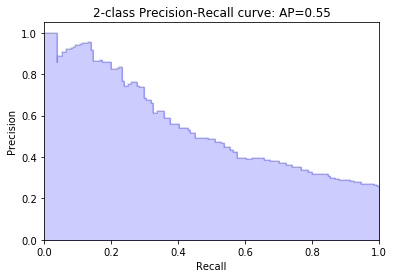

In [124]:
plot_precision_recall(Y_test, rf.predict_proba(X_test)[:,1])

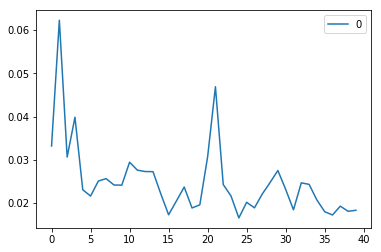

In [67]:
pandas.DataFrame(rf.steps[1][1].feature_importances_).plot()